In [47]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
class Ptr_Net(nn.Module):
    def __init__(self,hidden_size=128, embedding_size=128,num_directions=2,
                 input_size=2,batch_size=128,initialization_stddev=0.1):
        super(Ptr_Net, self).__init__()
        #Define Embedded
        self.Embed=torch.nn.Linear(input_size, embedding_size, bias=True)
        #Define Encoder
        self.Encoder=torch.nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        #Define Attention
        self.W_ref=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.W_q=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.v=torch.nn.Linear(num_directions * hidden_size, 1, bias=True)
        #Define Decoder
        self.Decoder=torch.nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        self.Softmax_Cross_Entrophy=torch.nn.CrossEntropyLoss(reduction='none')
    def forward(self, inputs, test_roads):
        #inputs:(batch,city,2)
        #test_roads:(batch,city)
        #basic parameter
        city=inputs.size()[1]
        max_time_steps=inputs.size()[1]
        already_played_penalty=1e6
        #Embedding
        #inputs:(batch,city,coor)
        City_Embedding=self.Embed(inputs)
        #Encoder
        #City_Embedding:(batch,city,embedding)
        Enc, (hn, cn) = self.Encoder(City_Embedding,None)
        #Attention and Decoder
        #Enc:(batch, city, num_directions * hidden_size)
        #hn: (batch,num_layers * num_directions,  hidden_size)
        #cn: (batch,num_layers * num_directions,  hidden_size)
        decoder_input = torch.zeros(Enc.size())
        decoder_state = (hn,cn)
        already_played_actions = torch.zeros(Enc.size()[1],max_time_steps)
        decoder_inputs = [decoder_input]
        path_loss=0
        for i in range(max_time_steps):
            attention_weight=torch.squeeze(
                self.v(
                    torch.tanh(
                        self.W_ref(Enc)+self.W_q(decoder_input)
                    )
                )
            )
            #attention_weight:(batch,city)
            path_loss+=self.Softmax_Cross_Entrophy(attention_weight,torch.LongTensor(test_roads[:,i].T).squeeze())
        return path_loss
    def get_road(self,inputs):
        #inputs:(batch,city,2)
        #basic parameter
        city=inputs.size()[1]
        max_time_steps=inputs.size()[1]
        already_played_penalty=1e6
        #Embedding
        #inputs:(batch,city,coor)
        City_Embedding=self.Embed(inputs)
        #Encoder
        #City_Embedding:(batch,city,embedding)
        Enc, (hn, cn) = self.Encoder(City_Embedding,None)
        #Attention and Decoder
        #Enc:(batch, city, num_directions * hidden_size)
        #hn: (batch,num_layers * num_directions,  hidden_size)
        #cn: (batch,num_layers * num_directions,  hidden_size)
        decoder_input = torch.zeros(Enc.size())
        decoder_state = (hn,cn)
        already_played_actions = torch.zeros(Enc.size()[0],max_time_steps)
        decoder_inputs = [decoder_input]
        decoder_outputs=[]
        for i in range(max_time_steps):
            attention_weight=torch.nn.functional.softmax(
                torch.squeeze(
                    self.v(torch.tanh(
                        self.W_ref(Enc)+self.W_q(decoder_input)
                    ))
                )-already_played_penalty*already_played_actions,dim=1
            )
            decoder_outputs.append(torch.argmax(attention_weight, dim=1))
            decoder_input=torch.unsqueeze(torch.einsum('ij,ijk->ik',attention_weight,Enc),dim=1).repeat(1,city,1)
            already_played_actions+=torch.zeros(Enc.size()[0],max_time_steps).scatter_(1,torch.unsqueeze(decoder_outputs[-1],dim=1),1)
        return decoder_outputs
class Critic_Net(nn.Module):
    def __init__(self,hidden_size=128, embedding_size=128,num_directions=2,
                 input_size=2,batch_size=128,initialization_stddev=0.1,mid_size=100):
        super(Critic_Net, self).__init__()
        #Define Embedded
        self.Embed=torch.nn.Linear(input_size, embedding_size, bias=True)
        #Define Encoder
        self.Encoder=torch.nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        #Define Attention
        self.W_ref=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.W_q=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.v=torch.nn.Linear(num_directions * hidden_size, 1, bias=True)
        #Define Decoder
        self.Processor=torch.nn.LSTM(input_size=embedding_size*2,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        self.last_layer=torch.nn.Sequential(
            torch.nn.Linear(embedding_size*2, mid_size, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(mid_size,1, bias=True)
        )
    def forward(self, inputs):
        #inputs:(batch,city,2)
        #basic parameter
        city=inputs.size()[1]
        max_time_steps=inputs.size()[1]
        #Embedding
        #inputs:(batch,city,coor)
        City_Embedding=self.Embed(inputs)
        #Encoder
        #City_Embedding:(batch,city,embedding)
        Enc, (hn, cn) = self.Encoder(City_Embedding,None)
        #Attention and Decoder
        #Enc:(batch, city, num_directions * hidden_size)
        #hn: (batch,num_layers * num_directions,  hidden_size)
        #cn: (batch,num_layers * num_directions,  hidden_size)
        processor_input = torch.zeros(Enc.size()[0],1,Enc.size()[2])
        #processor_input:(batch, city, num_directions * hidden_size)
        processor_state = (hn,cn)
        processor_inputs = [processor_input]
        for i in range(max_time_steps):
            processor_output,processor_state=self.Processor(processor_input,processor_state)
            attention_weight=torch.nn.functional.softmax(
                torch.squeeze(
                    self.v(torch.tanh(
                        self.W_ref(Enc)+self.W_q(processor_output.repeat(1,city,1))
                    ))
                ),dim=1
            )
            processor_input=torch.unsqueeze(torch.einsum('ij,ijk->ik',attention_weight,Enc),dim=1)
        output=torch.squeeze(self.last_layer(processor_output))
        return output
class Envs:
    def __init__(self):
        self.str='haha'
    def get_point(self,batch,city,coor):
        return torch.abs(torch.FloatTensor(np.random.normal(size=(batch,city,coor))))
    def get_length(self,point,road):
        length=torch.zeros(torch.IntTensor(road).size())
        batch=length.size()[0]
        city=length.size()[1]
        for i in range(batch):
            for j in range(city):
                if j!=city-1:
                    length[i,j]=float(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,j+1],:],2)))
                else:
                    length[i,j]=float(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,0],:],2)))
        return length
    def get_length_sum(self,point,road):
        length=torch.zeros(torch.IntTensor(road).size())
        batch=length.size()[0]
        city=length.size()[1]
        for i in range(batch):
            for j in range(city):
                if j!=city-1:
                    length[i,j]=float(torch.sqrt(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,j+1],:],2))))
                else:
                    length[i,j]=float(torch.sqrt(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,0],:],2))))
        return torch.sum(length,dim=1)
    def draw(self,points,roads):
        #point:(batch,city,coor)
        #road:(batch,city)
        batch=min(roads.shape[0],2)
        print(batch)
        city=len(roads[0])
        fig=plt.figure()
        for j in range(batch):
            ax=plt.subplot(1,batch,j+1)
            point=points[j].numpy()
            road=roads[j]
            for i in range(city-1):
                ax.plot(point[[road[i],road[i+1]],0],point[[road[i],road[i+1]],1],color='b')
            ax.plot(point[[road[city-1],road[0]],0],point[[road[city-1],road[0]],1],color='b')
        fig.show()
def training(env,ptr_net,critic_net,batch=3,city=5,coors=2,lr = 0.01,beta1=0.5,n_baseline_gradient_steps=5,
             train_steps=20):
    env=Envs()
    ptr_net=Ptr_Net()
    critic_net=Critic_Net()
    critic_op=optim.Adam(critic_net.parameters(), lr=lr, betas=(beta1, 0.999))
    ptr_op=optim.Adam(ptr_net.parameters(), lr=lr, betas=(beta1, 0.999))
    for i in range(train_steps):
        points=env.get_point(batch,city,coors)
        #points:(batch,city,coors)
        roads=np.array([list(item) for item in ptr_net.get_road(points)]).T
        #roads:(batch,city)
        real_length=env.get_length_sum(points,roads)
        for j in range(n_baseline_gradient_steps):
            est_length=critic_net(points)
            critic_loss=torch.sum(torch.pow(est_length-real_length,2))
            critic_net.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_op.step()
        adv=est_length-real_length
        ptr_loss=torch.dot(ptr_net(points,roads),adv)
        ptr_net.zero_grad()
        ptr_loss.backward(retain_graph=True)
        ptr_op.step()
        if i%10==0:
            print('i:'+str(i))
            print('mean_length:'+str(torch.mean(real_length)))
            print('bsln_error:'+str(critic_loss))
    return (ptr_net,critic_net)

mean_length_before_training:tensor(9.9727)
length_real_of_picture_before_training:[10.218061  11.2829075]
est_real_of_picture_before_training:[-0.0074852  -0.00521827]
2


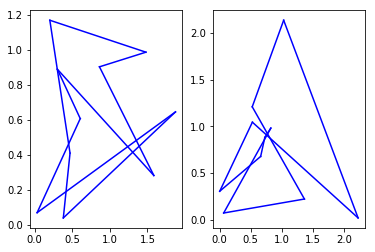

In [56]:
env=Envs()
ptr_net=Ptr_Net()
critic_net=Critic_Net()
points=env.get_point(100,10,2)
#data visualization before training
roads=np.array([list(item) for item in ptr_net.get_road(points)]).T
print('mean_length_before_training:'+str(torch.mean(env.get_length_sum(points,roads))))
print('length_real_of_picture_before_training:'+str(env.get_length_sum(points,roads).numpy()[0:2]))
print('est_real_of_picture_before_training:'+str(critic_net(points).detach().numpy()[0:2]))
env=Envs()
env.draw(points,roads)
 
    

In [57]:
ptr_net,critic_net=training(env,ptr_net,critic_net,batch=100,city=5,coors=2,lr = 0.01,beta1=0.5,
                            n_baseline_gradient_steps=10,train_steps=100) 

i:0
mean_length:tensor(5.2726)
bsln_error:tensor(238.5752, grad_fn=<SumBackward0>)
i:10
mean_length:tensor(4.7980)
bsln_error:tensor(75.8361, grad_fn=<SumBackward0>)
i:20
mean_length:tensor(4.8594)
bsln_error:tensor(24.4023, grad_fn=<SumBackward0>)
i:30
mean_length:tensor(4.7752)
bsln_error:tensor(4.0688, grad_fn=<SumBackward0>)
i:40
mean_length:tensor(4.7838)
bsln_error:tensor(2.2189, grad_fn=<SumBackward0>)
i:50
mean_length:tensor(4.8625)
bsln_error:tensor(12.7364, grad_fn=<SumBackward0>)
i:60
mean_length:tensor(5.1402)
bsln_error:tensor(1.4313, grad_fn=<SumBackward0>)
i:70
mean_length:tensor(4.5327)
bsln_error:tensor(0.2754, grad_fn=<SumBackward0>)
i:80
mean_length:tensor(4.8894)
bsln_error:tensor(0.2187, grad_fn=<SumBackward0>)
i:90
mean_length:tensor(4.8804)
bsln_error:tensor(0.7506, grad_fn=<SumBackward0>)


mean_length_after_training_for_5_city:tensor(9.0666)
length_real_of_picture_after_training_for_5_city:[ 6.0547667 10.753865 ]
length_est_of_picture_after_training_for_5_city:[4.73317  6.216194]
2


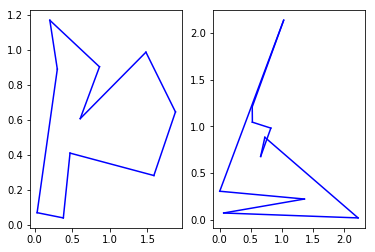

In [58]:
#data visualization after training for 5 city
roads=np.array([list(item) for item in ptr_net.get_road(points)]).T
print('mean_length_after_training_for_5_city:'+str(torch.mean(env.get_length_sum(points,roads))))
print('length_real_of_picture_after_training_for_5_city:'+str(env.get_length_sum(points,roads).numpy()[0:2]))
print('length_est_of_picture_after_training_for_5_city:'+str(critic_net(points).detach().numpy()[0:2]))
env=Envs()
env.draw(points,roads)

In [59]:
ptr_net,critic_net=training(env,ptr_net,critic_net,batch=100,city=10,coors=2,lr = 0.01,beta1=0.5,
                            n_baseline_gradient_steps=10,train_steps=100) 

i:0
mean_length:tensor(9.5842)
bsln_error:tensor(491.1923, grad_fn=<SumBackward0>)
i:10
mean_length:tensor(8.5047)
bsln_error:tensor(396.6216, grad_fn=<SumBackward0>)
i:20
mean_length:tensor(8.3939)
bsln_error:tensor(396.1255, grad_fn=<SumBackward0>)
i:30
mean_length:tensor(8.6202)
bsln_error:tensor(293.7785, grad_fn=<SumBackward0>)
i:40
mean_length:tensor(8.2797)
bsln_error:tensor(331.1723, grad_fn=<SumBackward0>)
i:50
mean_length:tensor(10.6062)
bsln_error:tensor(5945.7949, grad_fn=<SumBackward0>)
i:60
mean_length:tensor(9.0518)
bsln_error:tensor(270.8413, grad_fn=<SumBackward0>)
i:70
mean_length:tensor(8.8939)
bsln_error:tensor(118.3436, grad_fn=<SumBackward0>)
i:80
mean_length:tensor(9.5793)
bsln_error:tensor(168.6038, grad_fn=<SumBackward0>)
i:90
mean_length:tensor(9.0815)
bsln_error:tensor(93.4996, grad_fn=<SumBackward0>)


mean_length_after_training_for_10_city:tensor(9.0564)
length_real_of_picture_after_training_for_10_city:[8.223831 9.941527]
length_est_of_picture_after_training_for_10_city:[9.015301 9.412726]
2


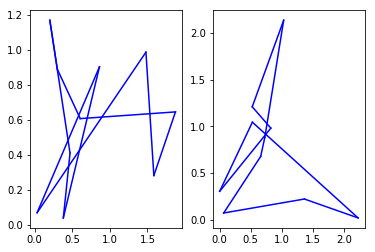

In [60]:
#data visualization after training for 10 city
roads=np.array([list(item) for item in ptr_net.get_road(points)]).T
print('mean_length_after_training_for_10_city:'+str(torch.mean(env.get_length_sum(points,roads))))
print('length_real_of_picture_after_training_for_10_city:'+str(env.get_length_sum(points,roads).numpy()[0:2]))
print('length_est_of_picture_after_training_for_10_city:'+str(critic_net(points).detach().numpy()[0:2]))
env=Envs()
env.draw(points,roads)

In [61]:
ptr_net,critic_net=training(env,ptr_net,critic_net,batch=100,city=10,coors=2,lr = 0.01,beta1=0.5,
                            n_baseline_gradient_steps=10,train_steps=100) 

i:0
mean_length:tensor(10.0969)
bsln_error:tensor(549.3848, grad_fn=<SumBackward0>)
i:10
mean_length:tensor(8.9721)
bsln_error:tensor(334.2621, grad_fn=<SumBackward0>)
i:20
mean_length:tensor(8.8330)
bsln_error:tensor(333.2878, grad_fn=<SumBackward0>)
i:30
mean_length:tensor(8.5426)
bsln_error:tensor(294.1574, grad_fn=<SumBackward0>)
i:40
mean_length:tensor(8.7460)
bsln_error:tensor(361.0802, grad_fn=<SumBackward0>)
i:50
mean_length:tensor(9.1028)
bsln_error:tensor(391.6080, grad_fn=<SumBackward0>)
i:60
mean_length:tensor(10.0832)
bsln_error:tensor(271.8071, grad_fn=<SumBackward0>)
i:70
mean_length:tensor(9.1148)
bsln_error:tensor(449.5476, grad_fn=<SumBackward0>)
i:80
mean_length:tensor(9.5038)
bsln_error:tensor(142.9999, grad_fn=<SumBackward0>)
i:90
mean_length:tensor(9.7009)
bsln_error:tensor(80.1992, grad_fn=<SumBackward0>)


mean_length_after_training_for_10_city:tensor(9.8931)
length_real_of_picture_after_training_for_10_city:[10.898501 11.322876]
length_est_of_picture_after_training_for_10_city:[ 8.500888 11.236565]
2


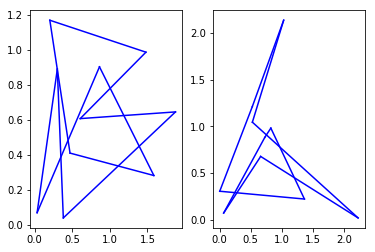

In [62]:
#data visualization after training for 10 city
roads=np.array([list(item) for item in ptr_net.get_road(points)]).T
print('mean_length_after_training_for_10_city:'+str(torch.mean(env.get_length_sum(points,roads))))
print('length_real_of_picture_after_training_for_10_city:'+str(env.get_length_sum(points,roads).numpy()[0:2]))
print('length_est_of_picture_after_training_for_10_city:'+str(critic_net(points).detach().numpy()[0:2]))
env=Envs()
env.draw(points,roads)